# Griffin-Lim Algorithm
This notebook demonstrates the Griffin-Lim Algorithm for reconstructing an audio signal from the magnitudes of its STFT coefficients.

In [1]:
import numpy as np
import STFT
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython

Text(0.5, 0, 'Time (sec)')

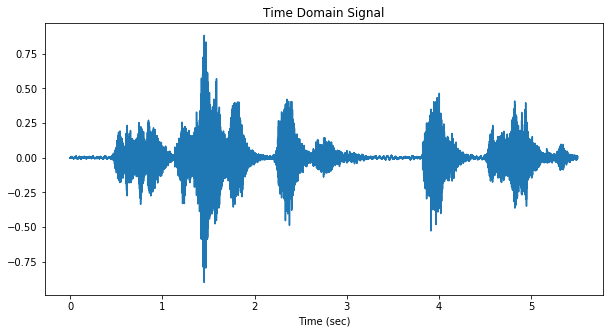

In [2]:
# load the observed audio
fs, x = wavfile.read('observed.wav')
x = x.astype(float) / 2**15

t = np.arange(x.size) / fs
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(t,x)
ax.set_title('Time Domain Signal')
ax.set_xlabel('Time (sec)')

Let us now compute the STFT. We first set the parameters and the window used in STFT.

Text(0.5, 1.0, 'Spectrogram of the Signal')

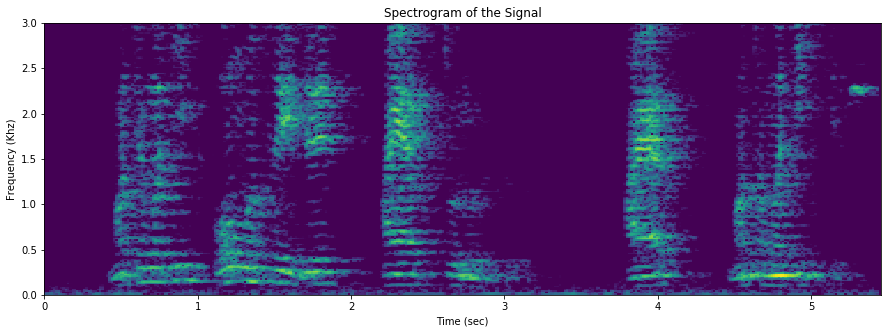

In [3]:
# STFT parameters
winms = 60 # length of the window in milliseconds
win = np.hamming(int(winms*fs/1000)) # we use a Hamming window but will modify it

hopms = 15 # hop size in milliseconds
hop = int(hopms*fs/1000) # hop size in samples

win2 = STFT.NormalizeWindow(win,hop) # this normalization step ensures that the STFT is self-inverting (or a Parseval frame)

# Compute the STFT
X = STFT.STFT(x,win2,hop)

# Display the STFT
Fr = np.array([0,3000]) # Frequency range to display
clim = [-5, 0] # magnitude range in dB

Norm = np.amax(abs(X))  
X2 = X / Norm # normalize so that the largest STFT coefficient magnitude is unity

fig, ax = plt.subplots(1,1,figsize = (15,5))
STFT.DisplaySTFT(X2,fs,hop,Fr,clim) # main display function for the STFT
ax.set_title('Spectrogram of the Signal')

We will discard the phase and retain only the magnitude. We then recover an audio signal using only the magnitude information from the STFT.

In [4]:
X_mag = np.abs(X)

#define the STFT and the inverse STFT operations as operators
S = lambda u : STFT.STFT(u, win2, hop)
Sinv = lambda U : np.real(STFT.ISTFT(U, win2, hop))[:x.size]

# define the operator that sets the magnitude to the observed magnitude
ProjMag = lambda U : U * X_mag / (np.abs(U) + 1e-20)

We assign random phase values initially. Listening to both signals, the initial reconstruction is a bit reverberant/phasy (with a headphone).

Note that the phase of a real signal needs to satisfy a conjugate symmetry condition. Here, I don't take that into account when assigning the initial phase. This is implicitly enforced by taking the real part after inverse STFT. After the first iteration, we don't need this 'real' operation in principle, but I keep it anyway.

Original Signal


Reconstruction with Random Phase Assigned to Given Magnitudes


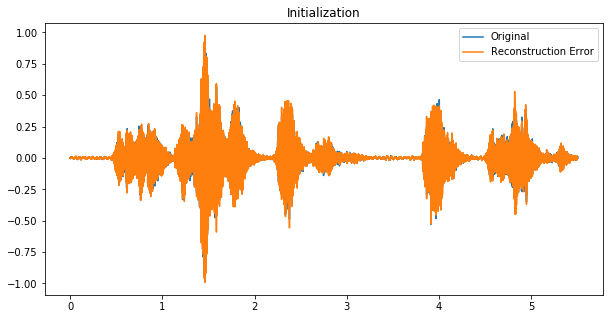

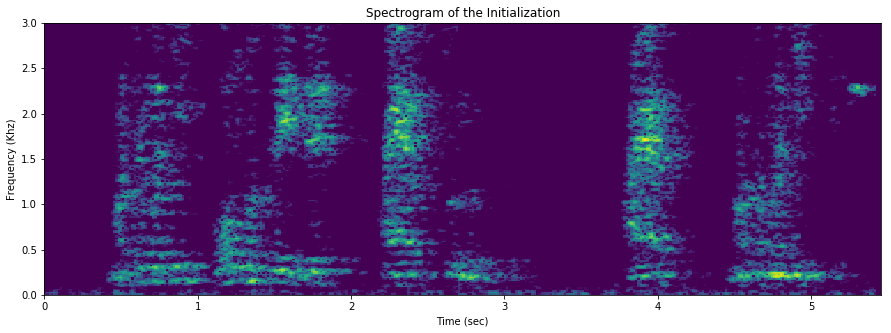

In [5]:
# initialize with arbitrary phase
Xr = X_mag * np.exp(1j * 2 * np.pi * np.random.uniform(0,1,X_mag.shape))
xr = Sinv(Xr)

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(t, x, label = 'Original')
ax.plot(t, x-xr, label = 'Reconstruction Error')
ax.legend()
ax.set_title('Initialization')

fig, ax = plt.subplots(1,1,figsize = (15,5))
STFT.DisplaySTFT(S(xr),fs,hop,Fr,clim) 
ax.set_title('Spectrogram of the Initialization')

print('Original Signal')
IPython.display.display(IPython.display.Audio(x, rate=fs))

print('Reconstruction with Random Phase Assigned to Given Magnitudes')
IPython.display.display(IPython.display.Audio(xr, rate=fs))

The Griffin-Lim iterations are as follows. For about 100 iterations, the reconstruction is hard to distinguish from the original without headphones.

In [ ]:
MAX_ITER = 100
for iters in range(MAX_ITER):
    print('\r % {:.2f} Complete'.format(100 * iters/MAX_ITER), end = '')
    # the STFT projection
    Xr = S(Sinv(Xr))
    # Magnitude projection
    Xr = ProjMag(Xr)
xr = Sinv(Xr)

 % 30.30 Complete

We now show the reconstruction. The phasiness of the initial reconstruction with random phase is greatly reduced.

Original


Reconstruction from the Magnitudes of STFT coefficients


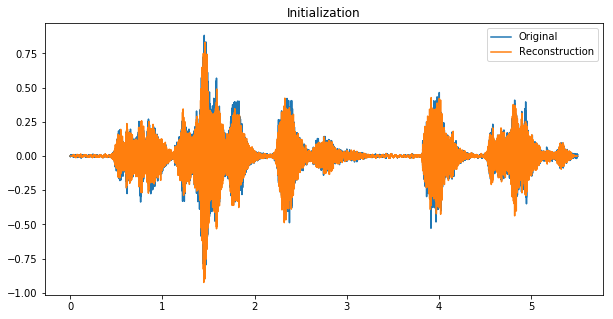

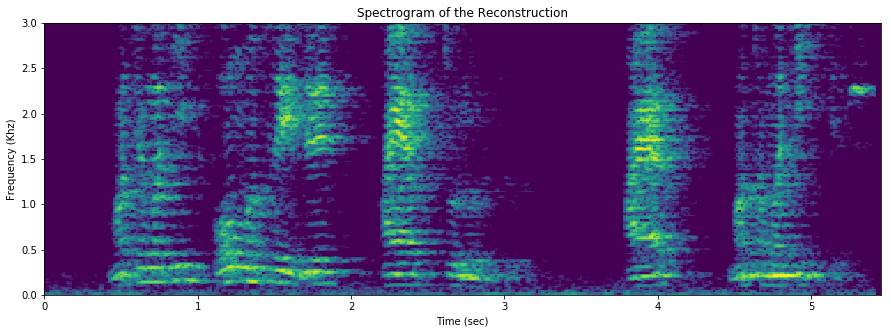

In [7]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(t, x, label = 'Original')
ax.plot(t, xr, label = 'Reconstruction')
ax.legend()
ax.set_title('Initialization')

fig, ax = plt.subplots(1,1,figsize = (15,5))
STFT.DisplaySTFT(S(xr),fs,hop,Fr,clim) 
ax.set_title('Spectrogram of the Reconstruction')

print('Original')
IPython.display.display(IPython.display.Audio(x, rate=fs))
print('Reconstruction from the Magnitudes of STFT coefficients')
IPython.display.display(IPython.display.Audio(xr, rate=fs))